In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%cd ../..

/home/den/dev/git/ozon-e-cup-2025


In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv("data/1__train_with_flags.csv")
test = pd.read_csv("data/1__test_with_flags.csv")

# resolution

In [ ]:
train.loc[:, ["resolution"]].mean()

resolution    0.066187
dtype: float64

Стратификацию по таргету будем делать всегда.

# brand_name

In [ ]:
bn_train = train[["brand_name", "resolution"]]
bn_test = test[["brand_name"]]

In [ ]:
bn_train["brand_name"].isna().sum(), bn_test["brand_name"].isna().sum()

(np.int64(80531), np.int64(5832))

In [ ]:
bn_train.brand_name.nunique(), bn_test.brand_name.nunique()

(4066, 863)

In [ ]:
2**12

4096

95% брендов из теста встречались в трейне.

<Axes: ylabel='Frequency'>

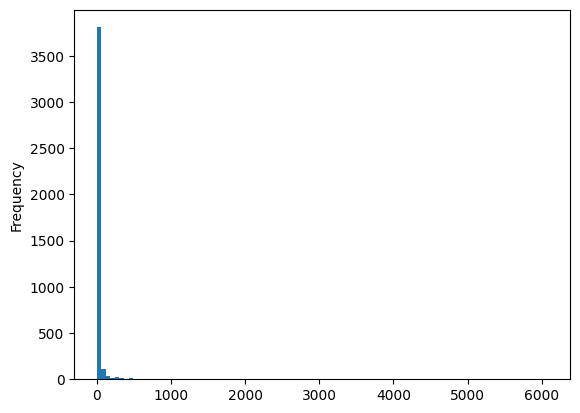

In [ ]:
bn_train_target_stats = bn_train.groupby("brand_name").resolution.agg(["mean", "count"])
bn_train_target_stats["count"].plot(kind="hist", bins=100)

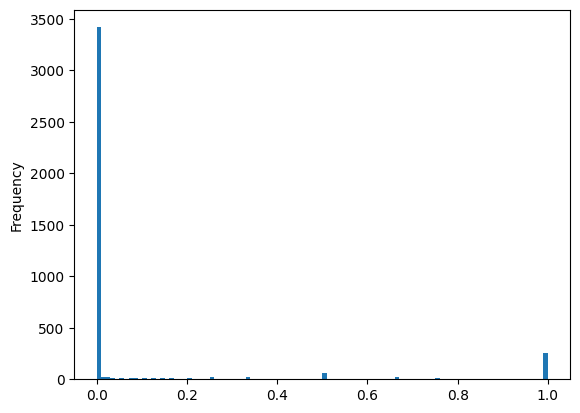

In [ ]:
bn_train_target_stats["mean"].plot(kind="hist", bins=100)

In [ ]:
bn_train_target_stats[bn_train_target_stats["count"] > 50].sort_values("mean", ascending=False).head(10)

,mean,count
brand_name,,
Econ,1.000000,55
ARIA,0.936508,63
Mivis,0.933619,467
Philips Sonicare,0.808642,162
JBL HARMAN,0.781250,96
Eurocell,0.762500,80
Redmi,0.725146,171
Pioneer,0.704641,237
Xbox,0.672131,122


При формировании train/val сплитов для обучения обязательно нужно следить за тем, чтобы один бренд был только в 1 сплите.

# SellerID

In [ ]:
sid_train = train[["SellerID", "resolution"]]
sid_test = test[["SellerID"]]

In [ ]:
sid_train["SellerID"].isna().sum(), sid_test["SellerID"].isna().sum()

(np.int64(0), np.int64(0))

In [ ]:
sid_train.SellerID.nunique(), sid_test.SellerID.nunique()

(11167, 2952)

In [ ]:
2**14

16384

65% продавцов из теста встречались в трейне. 

Поэтому необходимо будет превратить в NaN (0) некоторую часть SellerID в трейн части - чтобы не было "шока" на тесте.

<Axes: ylabel='Frequency'>

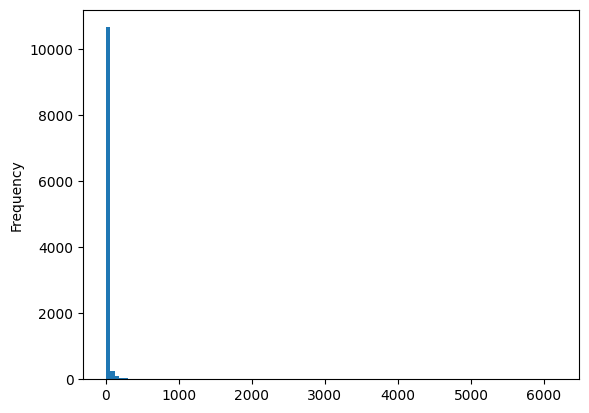

In [ ]:
sid_train_target_stats = sid_train.groupby("SellerID").resolution.agg(["mean", "count"])
sid_train_target_stats["count"].plot(kind="hist", bins=100)

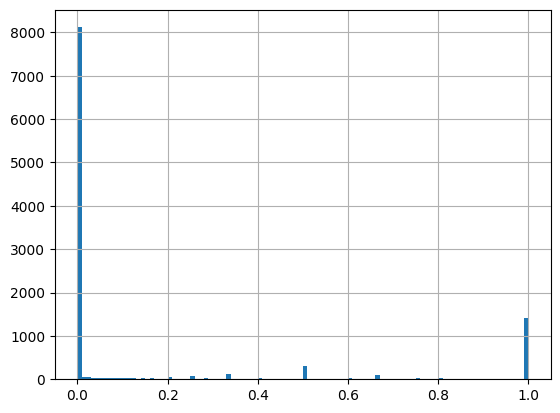

In [ ]:
sid_train_target_stats["mean"].hist(bins=100)

In [ ]:
sid_train_target_stats[sid_train_target_stats["count"] > 50].sort_values("mean", ascending=False).head(10)

,mean,count
SellerID,,
47,1.000000,61
501,1.000000,141
1256,1.000000,397
75,1.000000,110
2086,0.990385,104
350,0.979003,381
5268,0.974790,119
571,0.962264,53
2974,0.936508,63


Тоже нужно следить за тем, чтобы один продавец был только в 1 сплите (при обучении).

# CommercialTypeName4

In [ ]:
category_train = train[["CommercialTypeName4", "resolution"]]
category_test = test[["CommercialTypeName4"]]

In [ ]:
category_train.CommercialTypeName4.nunique(), category_test.CommercialTypeName4.nunique()

(634, 440)

In [ ]:
2**10

1024

99% категорий из теста есть в трейне.

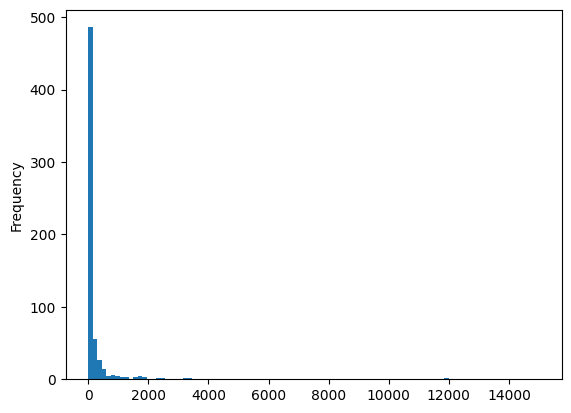

In [ ]:
category_train_target_stats = category_train.groupby("CommercialTypeName4").resolution.agg(["mean", "count"])
category_train_target_stats["count"].plot(kind="hist", bins=100)

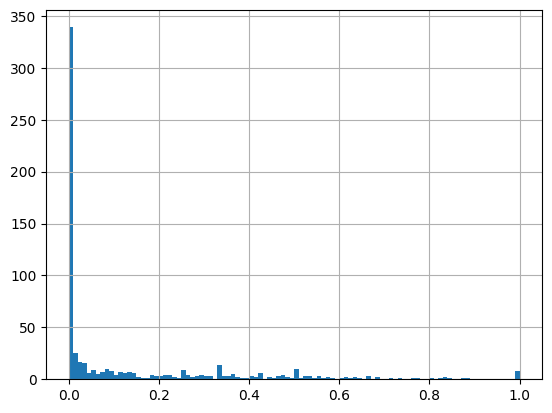

In [ ]:
category_train_target_stats["mean"].hist(bins=100)

In [ ]:
category_train_target_stats[category_train_target_stats["count"] > 1].sort_values("mean", ascending=False).head(10)

,mean,count
CommercialTypeName4,,
"Подсветка для электронной книги, ноутбука",1.000000,2
Аксессуары для умного дома,1.000000,2
Мышь Apple,1.000000,2
Настольный компьютер Apple,1.000000,2
Игровая приставка Playstation,0.882550,298
Ломтерезка,0.875000,8
Акустическая система с док-станцией,0.849057,53
Зарядное устройство сетевое Apple,0.833333,6
VR шлем,0.833333,42


# Сплиты для обучения (train\val)

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

Так как StratifiedGroupKFold не поддерживает группировку по нескольким столбцам, то сформируем группы (по SellerID, brand_name) таким образом, что в одну группу попадут строки с либо одинаковым SellerID, либо brand_name.

Используем networkx для формирования таких групп (используя графы).

In [ ]:
import networkx as nx
import numpy as np

In [ ]:
# Build a graph: nodes are row indices, edges connect rows with same SellerID or brand_name
G = nx.Graph()
for col in ["SellerID", "brand_name"]:
    for _, group in train.groupby(col):
        idx = group.index.tolist()
        # Connect all indices in this group
        for i in range(len(idx) - 1):
            G.add_edge(idx[i], idx[i + 1])

In [ ]:
print(f"Number of connected components: {len(list(nx.connected_components(G)))}")

Number of connected components: 3055


In [ ]:
# Find connected components (each is a group)
component_labels = {}
for group_id, component in enumerate(nx.connected_components(G)):
    for idx in component:
        component_labels[idx] = group_id

In [ ]:
# Assign group labels to train
train["union_group"] = train.index.map(component_labels)

In [ ]:
union_gr_train = train[["SellerID", "brand_name", "union_group", "resolution"]]
union_gr_train.head(5)

,SellerID,brand_name,union_group,resolution
0,1218,ACTRUM,5.0,0
1,1374,Red Line,5.0,0
2,1448,Talwar Brothers,448.0,0
3,715,NaN,223.0,0
4,715,NaN,223.0,0


Теперь можем применить StratifiedGroupKFold.

In [ ]:
sgkf = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=42)

In [ ]:
# Проверим, что действительно каждая группа только в одном из сплите
for i, (train_index, test_index) in enumerate(
    sgkf.split(train.drop(columns=["resolution"]), train["resolution"], groups=train["union_group"])
):
    print(f"Fold {i}:")
    print(f"  Train: group={train.loc[train_index, 'union_group'].value_counts()}")
    print(f"  Test:  group={train.loc[test_index, 'union_group'].value_counts()}")

Fold 0:
  Train: group=union_group
5.0       124744
15.0        6172
144.0       3009
64.0        1749
468.0       1548
           ...  
2743.0         2
1289.0         2
2729.0         2
708.0          2
43.0           2
Name: count, Length: 3054, dtype: int64
  Test:  group=union_group
2205.0    3
Name: count, dtype: int64
Fold 1:
  Train: group=union_group
2205.0    3
Name: count, dtype: int64
  Test:  group=union_group
5.0       124744
15.0        6172
144.0       3009
64.0        1749
468.0       1548
           ...  
2743.0         2
1289.0         2
2729.0         2
708.0          2
43.0           2
Name: count, Length: 3054, dtype: int64


In [ ]:
train[train["union_group"] == 15].shape

(6172, 49)

Всё ок.

In [ ]:
# Протестируем функцию
from src.splits import create_train_splits

splits = create_train_splits(data=train, n_splits=5)
len(splits)

5

# Сплиты для обучения и валидации финальной модели

После того, как мы подобрали гипер-параметры - хочется обучить модель на сплите (train/val), сформированном по-другому: например, чтобы train по-максимуму включал разных SellerID, brand_name (в сплитах для обучения - мы хотели обратного).

In [ ]:
# Протестируем функцию
from src.splits import create_final_splits

splits = create_final_splits(data=train, n_splits=2)
len(splits)

2

In [ ]:
train_ids, val_ids = splits[0]
print(f"Train size: {len(train_ids)}, Val size: {len(val_ids)}")
print(
    f"Train resolution mean: {train.loc[train_ids, 'resolution'].mean():.2f}, Val resolution mean: {train.loc[val_ids, 'resolution'].mean():.2f}"
)

Train size: 157758, Val size: 39440
Train resolution mean: 0.07, Val resolution mean: 0.07


In [ ]:
pd.concat(
    {
        "train_SellerID": train.loc[train_ids, "SellerID"]
        .value_counts()
        .sort_values(ascending=False)
        .iloc[:10]
        .apply(lambda x: f"{x} ({x / len(train_ids) * 100:.1f}%)"),
        "val_SellerID": train.loc[val_ids, "SellerID"]
        .value_counts()
        .sort_values(ascending=False)
        .iloc[:10]
        .apply(lambda x: f"{x} ({x / len(val_ids) * 100:.1f}%)"),
    },
    axis=1,
)

,train_SellerID,val_SellerID
SellerID,,
24,4976 (3.2%),1196 (3.0%)
69,2769 (1.8%),763 (1.9%)
442,2384 (1.5%),625 (1.6%)
6,2368 (1.5%),577 (1.5%)
27,1638 (1.0%),378 (1.0%)
66,1574 (1.0%),417 (1.1%)
15,1488 (0.9%),352 (0.9%)
58,1488 (0.9%),403 (1.0%)
198,1389 (0.9%),360 (0.9%)


In [ ]:
pd.concat(
    {
        "train_CommercialTypeName4": train.loc[train_ids, "CommercialTypeName4"]
        .value_counts()
        .sort_values(ascending=False)
        .iloc[:10]
        .apply(lambda x: f"{x} ({x / len(train_ids) * 100:.1f}%)"),
        "val_CommercialTypeName4": train.loc[val_ids, "CommercialTypeName4"]
        .value_counts()
        .sort_values(ascending=False)
        .iloc[:10]
        .apply(lambda x: f"{x} ({x / len(val_ids) * 100:.1f}%)"),
    },
    axis=1,
)

,train_CommercialTypeName4,val_CommercialTypeName4
CommercialTypeName4,,
Дисплеи для телефонов,12020 (7.6%),2982 (7.6%)
Корпуса для телефонов,9513 (6.0%),2447 (6.2%)
Аккумулятор для мобильного телефона,9490 (6.0%),2475 (6.3%)
Запчасти для телевизора,8204 (5.2%),1988 (5.0%)
"Картридж, чернила, тонер",6855 (4.3%),1715 (4.3%)
Шлейфы для телефонов,6798 (4.3%),1644 (4.2%)
"Запчасти для стиральной, сушильной машины",5422 (3.4%),1385 (3.5%)
Настольный компьютер,5063 (3.2%),1272 (3.2%)
Видеоигра Sony,3350 (2.1%),801 (2.0%)


In [ ]:
pd.concat(
    {
        "train_brand_name": train.loc[train_ids, "brand_name"]
        .value_counts()
        .sort_values(ascending=False)
        .iloc[:10]
        .apply(lambda x: f"{x} ({x / len(train_ids) * 100:.1f}%)"),
        "val_brand_name": train.loc[val_ids, "brand_name"]
        .value_counts()
        .sort_values(ascending=False)
        .iloc[:10]
        .apply(lambda x: f"{x} ({x / len(val_ids) * 100:.1f}%)"),
    },
    axis=1,
)

,train_brand_name,val_brand_name
brand_name,,
iQZiP,4873 (3.1%),1211 (3.1%)
ProFDetali,3883 (2.5%),928 (2.4%)
OEM,3431 (2.2%),844 (2.1%)
Sony,2463 (1.6%),590 (1.5%)
Levsha kaluga,2384 (1.5%),625 (1.6%)
HUAYU,2237 (1.4%),517 (1.3%)
OINO,2190 (1.4%),551 (1.4%)
HotComputers,1866 (1.2%),525 (1.3%)
Cameron Sino,1645 (1.0%),410 (1.0%)
